In [51]:
import io
import math
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [52]:
col_data = [("Genre", "|S20"),
            ("Artist", "|S50"),
            ("Track", "|S50"),
            ("Track ID", "|S22"),
            ("Popularity", int),
            ("Acousticness", float),
            ("Danceability", float),
            ("Duration (MS)", int),
            ("Energy", float),
            ("Instrumentalness", float),
            ("Key", "|S2"),
            ("Liveness", float),
            ("Loudness", float),
            ("Mode", "|S5"),
            ("Speechiness", float),
            ("Tempo", float),
            ("Time Signature", "|S3"),
            ("Valence", float)]

with io.open("SpotifyFeatures.csv", "r", encoding="utf-8") as f:
    data = np.genfromtxt(f, delimiter=",", skip_header=1, comments=None, dtype=col_data)
    
print(data.shape)

(132096,)


x array - 132096 x 10  
acousticness 5  
danceability 6    
energy 8  
instrumentalness 9  
liveness 11  
loudness 12  
speechiness 14  
tempo 15  
valence 17  

should we also include key, time signature, mode? (will need to map to numbers)  

y array - 132096 x 1  
genres (the true labels) mapped to numbers

In [53]:
x = np.empty((data.shape[0], 9))
y = np.empty((data.shape[0], 1))
genre_mapping_dict = {}
genre_idx = 0

for i in range(len(data)):
    row = data[i]
    genre = row[0].decode("utf-8")
    if not genre in genre_mapping_dict:
        genre_mapping_dict[genre] = genre_idx
        genre_idx += 1
    y[i] = genre_mapping_dict[genre]
    
    values = [row[5], row[6], row[8], 
              row[9], row[11], row[12], 
              row[14], row[15], row[17]]
    x[i, :] = values

In [54]:
# split X and Y into training and test 
from sklearn.model_selection import train_test_split
TEST_PERCENTAGE = 10

x_test, x_train, y_test, y_train = train_test_split(x, y, test_size = TEST_PERCENTAGE / 100)

In [55]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x_train, y_train)  # perform linear regression
y_pred = np.round(linear_regressor.predict(x_test))  # make predictions

correct = 0
for i in range(y_pred.shape[0]):
    if y_pred[i] == y_test[i]:
        correct += 1

print(correct / y_pred.shape[0])

0.07990848375754925


Explained variance ratio of training set: [0.96579436 0.03389201]
Explained variance ratio of the test set: [0.96570297 0.03398154]
Explained variance ratio of all data: [0.96571199 0.0339727 ]


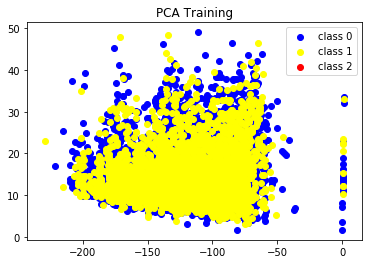

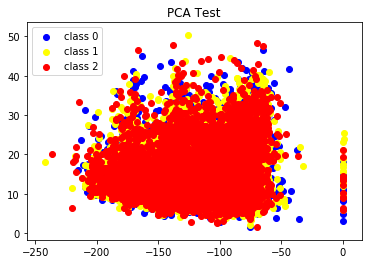

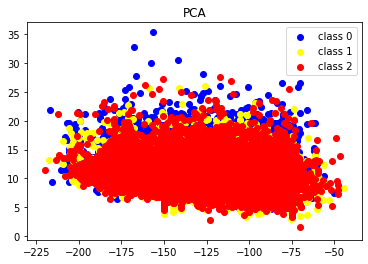

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train,y_train)
comp, evr = (pca.components_.T, pca.explained_variance_ratio_)
print('Explained variance ratio of training set: %s' % str(evr))
pca.fit(x_test,y_test)
comp1, evr1 = (pca.components_.T, pca.explained_variance_ratio_)
print('Explained variance ratio of the test set: %s' % str(evr1))
pca.fit(x,y)
comp2, evr2 = (pca.components_.T, pca.explained_variance_ratio_)
print('Explained variance ratio of all data: %s' % str(evr2))


class0 = len(np.where(y==0)[0])
class1 = len(np.where(y==1)[0]) + class0
class2 = len(np.where(y==2)[0]) + class1

pcaPlot = (x_train @ comp).T
plt.figure(0)
plt.title("PCA Training")
plt.scatter(pcaPlot[0][:class0],pcaPlot[1][:class0], c='blue', label="class 0")
plt.scatter(pcaPlot[0][class0:class1],pcaPlot[1][class0:class1], c='yellow', label="class 1")
plt.scatter(pcaPlot[0][class1:class2],pcaPlot[1][class1:class2], c='red', label="class 2")
plt.legend()
pcaPlot1 = (x_test @ comp).T
plt.figure(1)
plt.title("PCA Test")
plt.scatter(pcaPlot1[0][:class0],pcaPlot1[1][:class0], c='blue', label="class 0")
plt.scatter(pcaPlot1[0][class0:class1],pcaPlot1[1][class0:class1], c='yellow', label="class 1")
plt.scatter(pcaPlot1[0][class1:class2],pcaPlot1[1][class1:class2], c='red', label="class 2")
plt.legend()
pcaPlot2 = (x @ comp).T
plt.figure(2)
plt.title("PCA")
plt.scatter(pcaPlot2[0][:class0],pcaPlot2[1][:class0], c='blue', label="class 0")
plt.scatter(pcaPlot2[0][class0:class1],pcaPlot2[1][class0:class1], c='yellow', label="class 1")
plt.scatter(pcaPlot2[0][class1:class2],pcaPlot2[1][class1:class2], c='red', label="class 2")
plt.legend()